In [1]:
import pandas as pd
import sqlite3
import numpy as np
import json

def load_data_from_db(dbs, tbl):
    sc = list()
    for i, node in enumerate(dbs):
        conn = sqlite3.connect(node)
        
        query_cmd = f'SELECT *, strftime("%Y-%m-%d %H:%M:%S",timestamp) FROM {tbl} WHERE id IN ( SELECT MAX(id) FROM dbstatus GROUP BY timestamp);'

        df = pd.read_sql_query(query_cmd, conn)
        # df.drop('id', axis=1, inplace=True)
        # df.drop('totalblocks', axis=1, inplace=True)
        # df.drop('totaltransactions', axis=1, inplace=True)
        # df.drop('blocks', axis=1, inplace=True)
        # df = df.rename(columns={'ts': 'timestamp'})
        
        # df.astype({'headers': 'int', 'transactions': 'int', 'size': 'int', 'totalquery': 'int', 
        #           'queryfrom': 'int', 'queryto': 'int', 'totaldelay': 'int'}).dtypes

        # #df['totalhop'] = df['totalhop'].apply(json.loads)
        sc.append(df)        
        conn.close()
    return sc

In [2]:
#calculate centrality
import math
import numpy as np

def entropynorm(values):
    vs = np.array(values)
    num = vs.size
    tt = np.sum(vs)
    vs = vs/tt

    npi = np.sum(vs*np.log2(vs, out=np.zeros_like(vs), where=(vs!=0)))
    dpi = math.log2(num)
    return - npi/dpi

def fairnessnorm(values):
    vs = np.array(values)
    num = vs.size

    npi = np.sum(vs)
    npi = npi**2
    dpi = np.square(vs).sum()
    dpi = dpi*num
    
    fn = (npi/dpi - 1/num) / (1 - 1/num)
    
    return fn

values_list = [
                [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
                [0.17, 0.17, 0.13, 0.12, 0.11, 0.09, 0.07, 0.06, 0.05, 0.03],
                [0.42, 0.2, 0.14, 0.07, 0.04, 0.04, 0.03, 0.03, 0.02, 0.01]
                ]

print(entropynorm(values_list[2]))
print(fairnessnorm(values_list[1]))

0.7556018366014379
0.8056472313898059


In [3]:
import os

#PATH = "../blockchainnode/db_nodes"
# PATH = "../PoS_20221130_083413"
PATH = "../PoS_Starks_20230315_081210"

fdbs = [os.path.join(PATH, f) for f in os.listdir(PATH) if f.split(".")[-1] == 'db']
if len(fdbs) == 0:
    subdirs = [x[0] for x in os.walk(PATH)]
    for subd in subdirs:
        subbs = [os.path.join(subd, f) for f in os.listdir(subd) if f.split(".")[-1] == 'db']
        fdbs.extend(subbs)

fdbs.sort()
print(fdbs)

['../PoS_Starks_20230315_081210/node0.local/7031.db', '../PoS_Starks_20230315_081210/node1.local/7032.db', '../PoS_Starks_20230315_081210/node2.local/7033.db', '../PoS_Starks_20230315_081210/node3.local/7034.db', '../PoS_Starks_20230315_081210/node4.local/7035.db', '../PoS_Starks_20230315_081210/node5.local/7036.db', '../PoS_Starks_20230315_081210/node6.local/7037.db', '../PoS_Starks_20230315_081210/node7.local/7038.db']


[49, 39, 49, 33, 47, 43, 52, 54] 366
[312, 320, 306, 320, 316, 309, 307, 297] 2487
Fairness Proof 0.9768954275683358
Entropy Proof 0.9948333630901723


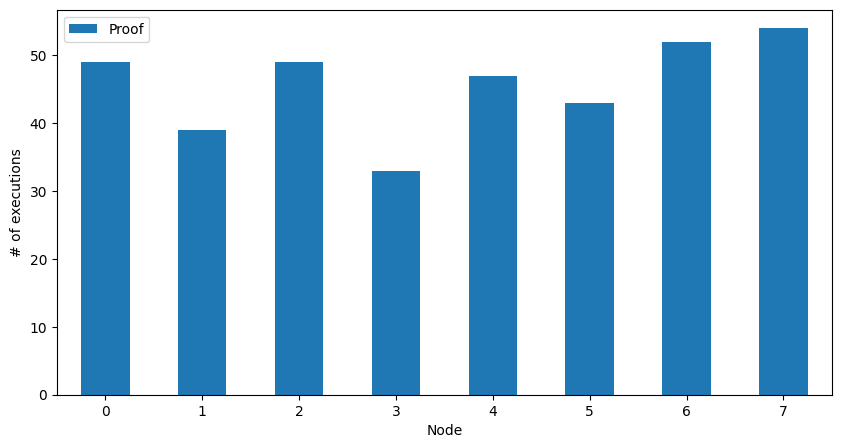

In [4]:
# Count chart for proof and verify
from matplotlib import pyplot as plt
    
dfs = load_data_from_db(fdbs, 'prooftbl')
proof = []
for i, df in enumerate(dfs):
    proof.append(df.shape[0])
print(proof, sum(proof))

dfs = load_data_from_db(fdbs, 'veriftbl')
verif = []
for i, df in enumerate(dfs):
    verif.append(df.shape[0])
print(verif, sum(verif))

ch_list = [proof]
bdf = pd.DataFrame(ch_list).transpose()
bdf.columns = ['Proof']
ax = bdf.plot.bar(rot=0, figsize=(10, 5))
plt.xlabel("Node")
plt.ylabel("# of executions")
plt.savefig('Num_Prover_Verifier.png', dpi=300, bbox_inches='tight')

print('Fairness Proof', fairnessnorm(proof))
# print('Fairness Verification', fairnessnorm(verif))

print('Entropy Proof', entropynorm(proof))
# print('Entropy Verification', entropynorm(verif))




Avg Proof[msec] 2521.3898044972043
Avg Verif[msec] 622.9109670624517


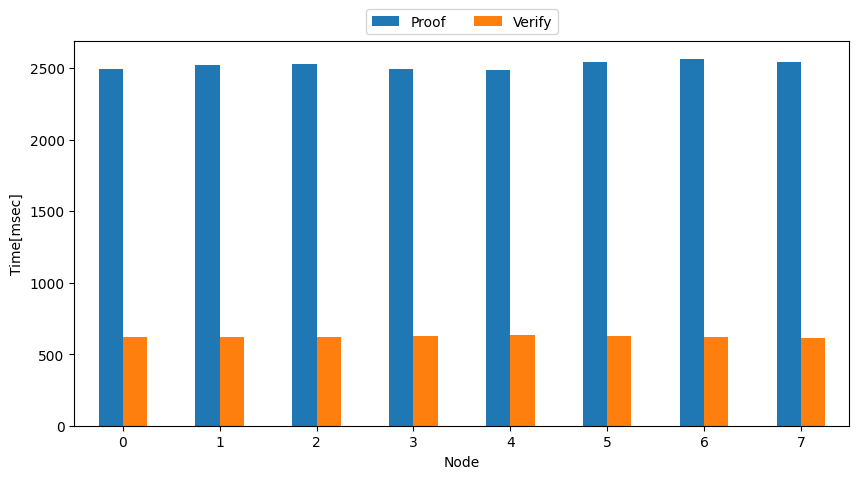

In [5]:
# Avg. Time chart for proof and verify
from matplotlib import pyplot as plt

unit = 1000000 #msec
dfs = load_data_from_db(fdbs, 'prooftbl')
proof = []
for i, df in enumerate(dfs):
    proof.append(df['timegenproof'].mean()/unit)
# print(proof)

dfs = load_data_from_db(fdbs, 'veriftbl')
veriffwd = []
# verifrev = []
for i, df in enumerate(dfs):
    veriffwd.append(df['timeveriffwd'].mean()/unit)
    # verifrev.append(df['timeverifrev'].mean()/unit)
# print(veriffwd)
# print(verifrev)

ch_list = [proof, veriffwd]
bdf = pd.DataFrame(ch_list).transpose()
bdf.columns = ['Proof', 'Verify']
ax = bdf.plot.bar(rot=0, figsize=(10, 5))
plt.xlabel("Node")
plt.ylabel("Time[msec]")
# plt.legend(loc='right')
# ax.set_yscale('log')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
          fancybox=True, shadow=False, ncol=5)

plt.savefig('Avg_Time_Proof_Verify.png', dpi=300, bbox_inches='tight')

print('Avg Proof[msec]', sum(proof)/len(proof))
print('Avg Verif[msec]', sum(veriffwd)/len(veriffwd))
# print('Avg Verif Back[msec]', sum(verifrev)/len(verifrev))


Avg size of verification Time T1    2052.836153
T2    6424.171327
T3    4371.335174
dtype: float64


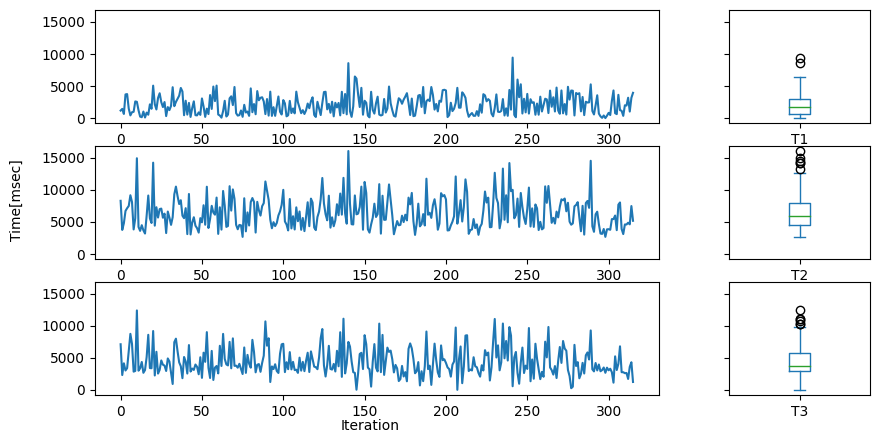

In [6]:
# Avg. Size chart for proof 
from matplotlib import pyplot as plt

unit = 1000 #kbyte
dfs = load_data_from_db(fdbs, 'veriftbl')
timelastblock = []
timercvlastblock = []
timercvpos = []
for i, df in enumerate(dfs):
    timelastblock.append(df['timelastblock'])
    timercvlastblock.append(df['timercvlastblock'])
    timercvpos.append(df['timercvpos'])
node = 4
ch_list = [timelastblock[node], timercvlastblock[node], timercvpos[node]]
bdf = pd.DataFrame(ch_list).transpose()
bdf.columns = ['Last Block', 'Receive Block', 'Receive PoS']

tdf = pd.DataFrame()
tdf['T1'] = (bdf['Receive Block'] - bdf['Last Block'])/1000000
tdf['T2'] = (bdf['Receive PoS'] - bdf['Last Block'])/1000000
tdf['T3'] = (bdf['Receive PoS'] - bdf['Receive Block'])/1000000

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 5), sharey=True, gridspec_kw={'width_ratios': [4, 1]})
fig.text(0.04, 0.5, 'Time[msec]', va='center', rotation='vertical')
fig.text(0.4, 0.04, 'Iteration', ha='center')

tdf['T1'].plot.line(ax=axes[0][0])
tdf['T1'].plot.box(ax=axes[0][1])
tdf['T2'].plot.line(ax=axes[1][0])
tdf['T2'].plot.box(ax=axes[1][1])
tdf['T3'].plot.line(ax=axes[2][0])
tdf['T3'].plot.box(ax=axes[2][1])

# plt.xlabel("Iteration")
# plt.ylabel("Time")
plt.savefig('Verifcation_Time.png', dpi=300, bbox_inches='tight')

print('Avg size of verification Time', tdf.mean())


[270.9560612244898, 271.6552564102564, 271.1809591836735, 272.64063636363636, 271.7115319148936, 271.68025581395347, 271.8944423076923, 272.2523333333333]
Avg size of proof 271.7464345689911


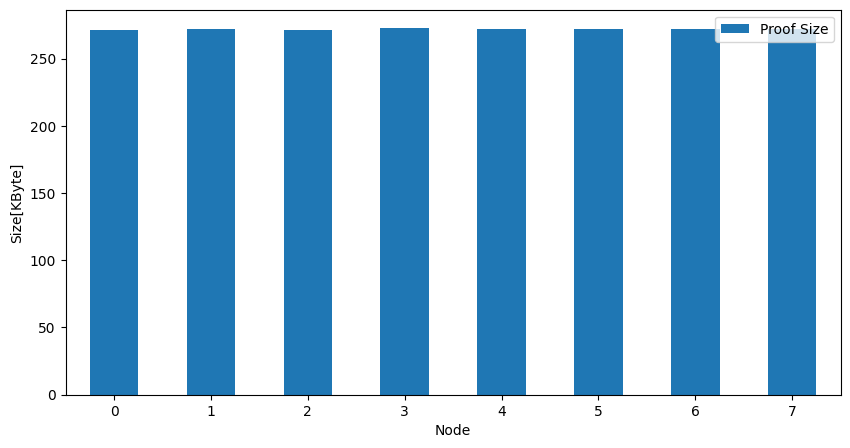

In [7]:
# Avg. Size chart for proof 
from matplotlib import pyplot as plt

unit = 1000 #kbyte
dfs = load_data_from_db(fdbs, 'prooftbl')
proof = []
for i, df in enumerate(dfs):
    proof.append(df['sizegenproof'].mean()/unit)
print(proof)

ch_list = [proof]
bdf = pd.DataFrame(ch_list).transpose()
bdf.columns = ['Proof Size']
ax = bdf.plot.bar(rot=0, figsize=(10, 5))
plt.xlabel("Node")
plt.ylabel("Size[KByte]")
plt.savefig('Avg_Size_Proof.png', dpi=300, bbox_inches='tight')

print('Avg size of proof', sum(proof)/len(proof))

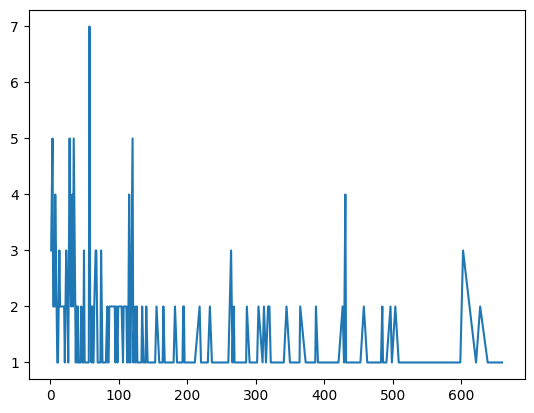

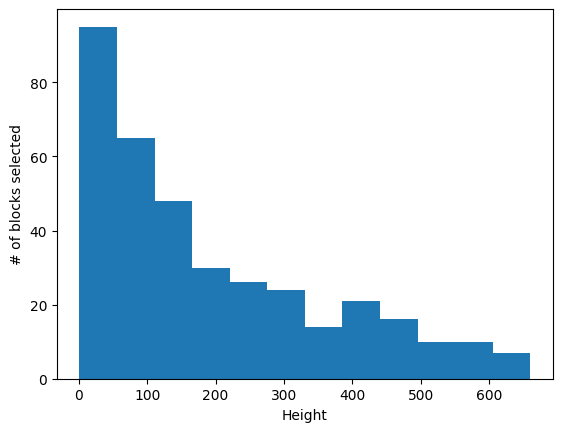

In [8]:
# List up proof block and show it in the time order 
from matplotlib import pyplot as plt

dfs = load_data_from_db(fdbs, 'prooftbl')
hash = []
for i, df in enumerate(dfs):
    for s in df['proofblock']:        
        hash.append(s)
# print(hash)

height = []
for i, df in enumerate(dfs):
    for h in df['proofheight']:        
        height.append(h)
# print(height)

ch_list = [hash, height]
bdf = pd.DataFrame(ch_list).transpose()
bdf.columns = ['Hash', 'Height']

bdf = bdf.sort_values(by=['Height'])
bdf2 = bdf.groupby(['Height'])['Height'].count().reset_index(name="Count")

plt.plot(bdf2['Height'], bdf2['Count'])

bdf = pd.DataFrame([height]).transpose()
ax = bdf.plot.hist(bins=12, label='Count')
ax.get_legend().remove()

plt.xlabel("Height")
plt.ylabel("# of blocks selected")

plt.savefig('Proof_Blocks.png', dpi=300, bbox_inches='tight')



0.5885774445707315 0.958332726399315
0.5553131544406986 0.9391373603019073
0.3804233831757093 0.9166987202666844


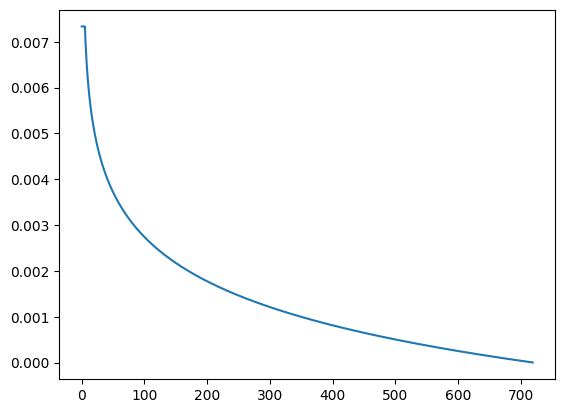

In [9]:
import numpy as np
 
def cal_evenness1(vdf, vmax):
    vdf['weight'] = (vmax - vdf['Height'])
    vdf['norm_cnt1'] = vdf['Count']/vdf['weight']
    values = vdf['norm_cnt1'].to_list()
    nf = fairnessnorm(values)
    ne = entropynorm(values)
    print(nf, ne)
    
def cal_evenness2(vdf, vmax):
    vdf['norm_cnt2'] = vdf['Count']*vdf['Height']
    values = vdf['norm_cnt2'].to_list()
    nf = fairnessnorm(values)
    ne = entropynorm(values)
    print(nf, ne)

def cal_acc_prob(vmax):
    pis = []
    for i in range(vmax):
        pi = 0
        for j in range(max(i, 5), vmax):
            pi += 1/(j-1)
        # pi = pi*np.log10(pi)
        pis.append(pi)
    
    # mpis = max(pis)
    mpis = sum(pis)
    # https://en.wikipedia.org/wiki/Entropy_(information_theory)
    pis2 = [x /mpis for x in pis]
    pis3 = [-np.log2(x) for x in pis2] 
    # print(pis2)
    plt.plot(pis2)
    return pis2, pis3

def cal_evenness3(vdf, vmax):
    # vdf = sdf.copy()
    pis, pis2 = cal_acc_prob(vmax)

    # vdf.set_index('Height', inplace=True)
    # vdf = vdf.reindex(list(range(0,vmax)),fill_value=0)    
    # vdf['weight'] =  pis
    # vdf['weight3'] = [pis2[v] for v in vdf['Height'].values]
    vdf['weight3'] = [1/pis[v] for v in vdf['Height'].values]
    # print('weights',vdf)
    vdf['norm_cnt3'] = vdf['Count']*vdf['weight3']
    # vdf['norm_cnt'] = vdf['Count2']*vdf['weight']

    # plt.plot(vdf['weight3'])

    # values = vdf['Count'].to_list()
    # vs = np.array(values)
    # num = vs.size
    # tt = np.sum(vs)
    # vs = vs/tt
    # # print('p(x)', vs)

    # ci_values =  vdf['weight3'].to_list()
    # ci = np.array(ci_values)
    # # print('CI=====', ci)

    # se = vs*ci
    # npi = np.sum(vs*ci)
    # dpi = math.log2(num)
    # print('Entropy', npi/dpi)
    # plt.plot(vs, 'g')
    # # plt.plot(ci, 'r')
    # plt.plot(se, 'b')

    values = vdf['norm_cnt3'].to_list()
    nf = fairnessnorm(values)
    ne = entropynorm(values)
    print(nf, ne)
    # print(values)
    # plt.plot(values)
    
    # print(vdf['norm_cnt'])
    
    # vdf['norm_cnt'].plot()
cal_evenness1(bdf2, 720)
cal_evenness2(bdf2, 720)
cal_evenness3(bdf2, 720)

# print(bdf2)
# plt.plot(bdf2['norm_cnt1']*50, 'r')
# plt.plot(bdf2['norm_cnt2']/1284, 'b')
# plt.plot(bdf2['norm_cnt3']/20, 'g')



In [10]:
def cal_acc_prob(vmax):
    pis = []
    for i in range(vmax):
        pi = 0
        for j in range(i, vmax):
            pi += 1/(j+1)
        pis.append(pi*np.log10(i+1))
    # print(pis)
    
    return pis
pis = cal_acc_prob(720)
# plt.plot(pis)
bdf = pd.DataFrame([pis]).transpose()
bdf.columns = ['Count']
# ax = bdf.plot.hist(bins=12, label='Count')
bdf2

,Height,Count,weight,norm_cnt1,norm_cnt2,weight3,norm_cnt3
0,1,3,719,0.004172,3,136.372023,409.116069
1,2,4,718,0.005571,8,136.372023,545.488092
2,3,5,717,0.006974,15,136.372023,681.860115
3,4,2,716,0.002793,8,136.372023,272.744046
4,5,2,715,0.002797,10,136.372023,272.744046
...,...,...,...,...,...,...,...
240,628,2,92,0.021739,1256,5296.004112,10592.008224
241,639,1,81,0.012346,639,6066.663008,6066.663008
242,642,1,78,0.012821,642,6314.512680,6314.512680
243,650,1,70,0.014286,650,7079.180691,7079.180691


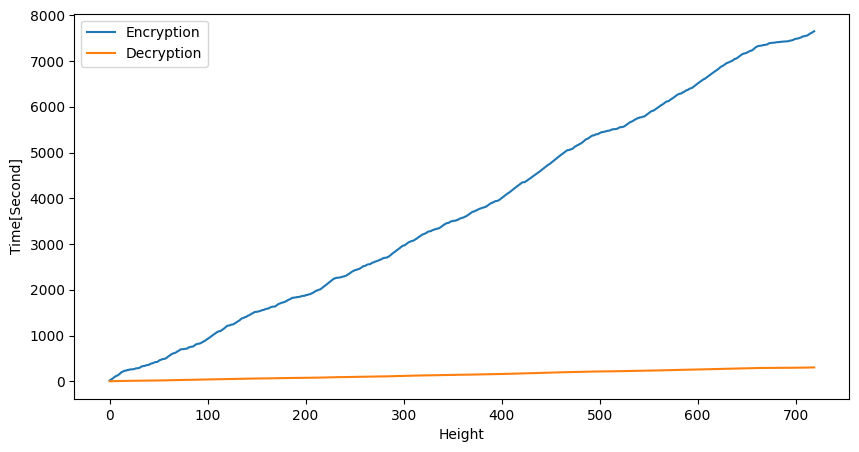

In [11]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

df = pd.read_csv('../ppos.divid.csv', header=None)
df = df.rename(columns={0: "Encryption", 1: "Decryption"})

# df1 = pd.read_csv('../ppos.size.csv', header=None)
# df1 = df1.rename(columns={0: "Encryption", 1: "Decryption", 2: "Size"})

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df['Encryption']/1000, label="Encryption")
ax.plot(df['Decryption']/1000, label="Decryption")

# twin1 = ax.twinx()
# twin1.plot(df1['Size'], "g-.", label="Size")

ax.ticklabel_format(useOffset=False, style='plain')
plt.xlabel("Height")
plt.ylabel("Time[Second]")
plt.legend()
plt.savefig('Encrypt_Height.png', dpi=300, bbox_inches='tight')
